<a href="https://colab.research.google.com/github/Sendy45/NeuralNetworkFromScracth/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist, fashion_mnist
from tqdm.auto import tqdm

In [49]:
class NeuralNetwork:
    def __init__(self, layers_sizes, activations, initializers=[]):
        # Check for right number of layers
        if len(layers_sizes) != len(activations) + 1:
            raise Exception("Invalid number of layers")

        self.layers_sizes = layers_sizes
        self.activations = activations
        self.initializers = initializers

        self._eps = 1e-08 # Avoid dividing by zero
        self.lr = 0.001
        self.lambda_ = 0.0
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.loss_type = "cross_entropy"
        self.optimizer = "adam"


        if not initializers:
            self._set_default_initializers()

        self.weights = []
        self.biases = []
        # Create weights and biases
        for i in range(len(layers_sizes) - 1):
            in_size = layers_sizes[i]
            out_size = layers_sizes[i + 1]

            self.weights.append(self._initialize_weights(in_size, out_size, initializers[i]))
            self.biases.append(np.zeros((out_size, 1), dtype=np.float64))

    def save(self, path):
        np.savez(
            path,
            weights=np.array(self.weights, dtype=object),
            biases=np.array(self.biases, dtype=object),
            layers_sizes=np.array(self.layers_sizes),
            activations=np.array(self.activations, dtype=object),
            initializers=np.array(self.initializers, dtype=object),
            lambda_=self.lambda_,
            lr=self.lr,
            loss_type=self.loss_type,
            beta1=self.beta1,
            beta2=self.beta2,
            optimizer=self.optimizer
        )

    @staticmethod
    def load(path):
        data = np.load(path, allow_pickle=True)

        model = NeuralNetwork(
            layers_sizes=list(data["layers_sizes"]),
            activations=list(data["activations"]),
            initializers=list(data["initializers"])
        )

        model.weights = list(data["weights"])
        model.biases = list(data["biases"])

        model.lambda_ = data["lambda_"].item()
        model.lr = data["lr"].item()
        model.loss_type = data["loss_type"].item()
        model.beta1 = data["beta1"].item()
        model.beta2 = data["beta2"].item()
        model.optimizer = data["optimizer"].item()

        return model

    # Prints a summary of the neural network architecture
    def summary(self):

        print("=" * 50)
        print("Model Summary")
        print("=" * 50)

        total_params = 0

        for i in range(len(self.weights)):
            w = self.weights[i]
            b = self.biases[i]

            in_units = w.shape[1]
            out_units = w.shape[0]

            params = w.size + b.size
            total_params += params

            print(f"Layer {i+1}")
            print(f"  Input units:  {in_units}")
            print(f"  Output units: {out_units}")
            print(f"  Parameters:   {params}")
            print("-" * 50)

        print(f"Total parameters: {total_params}")
        print("=" * 50)

    # Activation functions and their derivatives
    @staticmethod
    def _relu(z):
        return np.maximum(0, z)

    @staticmethod
    def _relu_deriv(z):
        return z > 0

    @staticmethod
    def _sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def _sigmoid_deriv(z):
        sigmoid_z = NeuralNetwork._sigmoid(z)
        return sigmoid_z * (1 - sigmoid_z)

    @staticmethod
    def _tanh(z):
        return np.tanh(z)

    @staticmethod
    def _tanh_deriv(z):
        return 1 - np.tanh(z) ** 2

    @staticmethod
    def _linear(z):
        return z

    @staticmethod
    def _linear_deriv(z):
        return np.ones_like(z)

    @staticmethod
    def _softmax(z):
        # numerical stability
        z = z - np.max(z, axis=0, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    @staticmethod
    def _softmax_deriv(z, da):
        a = NeuralNetwork._softmax(z)
        # dz = a * (da - sum(da * a))
        s = np.sum(da * a, axis=0, keepdims=True)
        dz = a * (da - s)
        return dz

    # Activation functions
    # Return activation based on input and activation function selected
    def _activation_function(self, z, act_type):
        if act_type == "relu":
            return NeuralNetwork._relu(z)
        elif act_type == "sigmoid":
            return NeuralNetwork._sigmoid(z)
        elif act_type == "tanh":
            return NeuralNetwork._tanh(z)
        elif act_type == "softmax":
            return NeuralNetwork._softmax(z)
        elif act_type == "linear":
            return NeuralNetwork._linear(z)
        else:
            raise Exception("Invalid activation function")

    # Activation functions derivatives
    # Return dZ based on input, dA, and activation function selected
    def _activation_deriv(self, z, da, act_type):
        if act_type == "relu":
            return NeuralNetwork._relu_deriv(z) * da
        elif act_type == "sigmoid":
            return NeuralNetwork._sigmoid_deriv(z) * da
        elif act_type == "tanh":
            return NeuralNetwork._tanh_deriv(z) * da
        elif act_type == "softmax":
            # Derivative already multiply with dA
            return NeuralNetwork._softmax_deriv(z, da)
        elif act_type == "linear":
            return NeuralNetwork._linear_deriv(z) * da
        else:
            # No derivative
            return np.ones_like(z) * da

    def _set_default_initializers(self):
        for act_type in self.activations:
            if act_type == "relu":
                self.initializers.append("he")
            elif act_type in ["sigmoid", "tanh", "softmax", "linear"]:
                self.initializers.append("xavier")
            else:
                raise Exception("Invalid activation function")


    def _initialize_weights(self, in_size, out_size, init_type):

        if init_type == "he":
            # W ~ N(0, √(2/in))
            std = np.sqrt(2.0 / in_size)
            W = np.random.randn(out_size, in_size) * std

        elif init_type == "xavier":
            # U(-√(6/(in+out)),√(6/(in+out)))
            limit = np.sqrt(6.0 / (in_size + out_size))
            W = np.random.uniform(-limit, limit, (out_size, in_size))

        else:
            W = np.random.randn(out_size, in_size) * 0.01

        return W.astype(np.float64)



    # One hot encoding for y_true - convert format into a matrix for calculations
    def _one_hot_encoding(self, y):
        one_hot_y = np.zeros((y.size, self.layers_sizes[-1]))
        one_hot_y[np.arange(y.size), y] = 1
        return one_hot_y.T

    # Forward function - feed input and get prediction
    def _forward(self, x):
        # Z = W * A + B
        # A - output (after activation function)
        # Also next layer input
        z_lst = []
        a_lst = []

        a_lst.append(x) # acts as A0

        # Goes through the entire network
        for i in range(len(self.weights)):
            z = np.dot(self.weights[i], a_lst[i]) + self.biases[i]
            z_lst.append(z)
            # Activation
            a = self._activation_function(z, self.activations[i])
            a_lst.append(a)

        return z_lst, a_lst

    # Backward function - locates the origin of the loss and tweaks it
    def _backward(self, z_lst, a_lst, x, y_true):

      # Size - for relative, pair batch ratio
      m = y_true.size
      # Delta of weights and biases
      # The amount of change each weight and bias gets change by
      dw_lst = [np.zeros_like(w, dtype=np.float64) for w in self.weights]
      db_lst = [np.zeros_like(b, dtype=np.float64) for b in self.biases]

      # Start with the last layer
      dz = None
      L = len(self.weights)

      # Backpropagation: iterate layers in reverse order (from last to first)
      # Compute gradients dW and dB for each layer
      for i in reversed(range(L)):

          if i == L - 1:
              # Output layer:
              # dA = ∂J/∂A_L
              # This is the derivative of the loss w.r.t. the network output
              da = self._loss_derivative(a_lst[i + 1], y_true)
          else:
              # Hidden layers:
              # dA = W_{i+1}^T · dZ_{i+1}
              # Propagate the gradient from the next layer back to this layer
              da = self.weights[i + 1].T.dot(dz)

          # dZ_i = dA_i ⊙ f'(Z_i)
          # Apply derivative of activation function element-wise
          dz = self._activation_deriv(z_lst[i], da, self.activations[i])

          # dW_i = (1/m) · dZ_i · A_{i}^T
          # Gradient of the loss w.r.t. weights of layer i
          dw_lst[i] = (1 / m) * dz.dot(a_lst[i].T)

          # dB_i = (1/m) · sum(dZ_i) over the batch
          # Gradient of the loss w.r.t. biases of layer i
          db_lst[i] = (1 / m) * np.sum(dz, axis=1, keepdims=True)

      # Return gradients for all layers
      return dw_lst, db_lst

    # Loss derivative - for the last layer based on the loss-type
    def _loss_derivative(self, y_pred, y_true):
        one_hot = self._one_hot_encoding(y_true) # y_true formatting

        # Division by m happens in backward function
        if self.loss_type == "cross_entropy":
            # - y_true / y_pred
            return -(one_hot / (y_pred + self._eps))

        elif self.loss_type == "mse":
            # 2 * (y_pred - y_true)
            return 2 * (y_pred - one_hot)

        else:
            raise Exception("Invalid loss function")

    # Compute loss for logging
    def _compute_loss(self, y_pred, y_true):
        one_hot = self._one_hot_encoding(y_true)  # shape: (num_classes, N)
        m = y_true.size

        if self.loss_type == "cross_entropy":
          # -1/m * ∑ (y_true * log(y_pred))
          data_loss = -np.sum(one_hot * np.log(y_pred + self._eps)) / m
        elif self.loss_type == "mse":
          # 1/m * ∑ ((y_pred - y_true)^2)
          data_loss = np.mean((y_pred - one_hot) ** 2)
        else:
          raise Exception("Invalid loss function")

        # L2 regularization term: (λ / 2m) * sum(||W||^2)
        reg_loss = 0.0
        for W in self.weights:
            reg_loss += np.sum(W ** 2)

        reg_loss = (self.lambda_ / (2 * m)) * reg_loss

        return data_loss + reg_loss


    # Update weights and biases
    # Uses dW and dB from backward function
    # lr = learning rate
    # high lr - impact the model fast, can overshoot
    # low lr - learns slower, wont overshoot
    # Lambda λ = Counter overfitting by punishing big weights
    # Force weights to be small but not zero (w = 0 -> no impact on the model)
    # Beta = momentum factor
    def _update(self, dw_lst, db_lst, optimizer_state):
      optimizer_state["t"] += 1

      for i in range(len(self.weights)):
        dw = dw_lst[i] + self.lambda_ * self.weights[i]

        if self.optimizer == "momentum":
          optimizer_state["v_w"][i] = self.beta1 * optimizer_state["v_w"][i] + dw
          optimizer_state["v_b"][i] = self.beta1 * optimizer_state["v_b"][i] + db_lst[i]

          update_w = optimizer_state["v_w"][i]
          update_b = optimizer_state["v_b"][i]

        elif self.optimizer == "adam":
          optimizer_state["m_w"][i] = self.beta1 * optimizer_state["m_w"][i] + (1 - self.beta1) * dw
          optimizer_state["m_b"][i] = self.beta1 * optimizer_state["m_b"][i] + (1 - self.beta1) * db_lst[i]

          optimizer_state["v_w"][i] = self.beta2 * optimizer_state["v_w"][i] + (1 - self.beta2) * (dw ** 2)
          optimizer_state["v_b"][i] = self.beta2 * optimizer_state["v_b"][i] + (1 - self.beta2) * (db_lst[i] ** 2)

          m_w_hat = optimizer_state["m_w"][i] / (1 - self.beta1 ** optimizer_state["t"])
          m_b_hat = optimizer_state["m_b"][i] / (1 - self.beta1 ** optimizer_state["t"])

          v_w_hat = optimizer_state["v_w"][i] / (1 - self.beta2 ** optimizer_state["t"])
          v_b_hat = optimizer_state["v_b"][i] / (1 - self.beta2 ** optimizer_state["t"])


          update_w = m_w_hat / (np.sqrt(v_w_hat) + self._eps)
          update_b = m_b_hat / (np.sqrt(v_b_hat) + self._eps)



        elif self.optimizer == "rmsprop":
          optimizer_state["v_w"][i] = self.beta2 * optimizer_state["v_w"][i] + (1 - self.beta2) * (dw ** 2)
          optimizer_state["v_b"][i] = self.beta2 * optimizer_state["v_b"][i] + (1 - self.beta2) * (db_lst[i] ** 2)

          update_w = dw / (np.sqrt(optimizer_state["v_w"][i]) + self._eps)
          update_b = db_lst[i] / (np.sqrt(optimizer_state["v_b"][i]) + self._eps)

        else:
          # Classic SGD
          update_w = dw
          update_b = db_lst[i]

        # W = W - lr * (dW + λ * W)
        self.weights[i] -= self.lr * update_w
        self.biases[i] -= self.lr * update_b

    # Calculte model accuracy
    @staticmethod
    def accuracy(predictions, y):
      return np.sum(predictions==y) / y.size

    # Converts final layer activation to predicted class labels
    def _decode_output(self, output):
      if output.shape[0] == 1:  # Binary classification
          return (output > 0.5).astype(int).flatten()
      else:  # Multi-class (softmax)
          return np.argmax(output, axis=0)


    # Compile the model and trains it
    # x - input features
    # y - labels
    # lr - learning rate
    # epochs - num of iterations over the data
    # batch_size - data size before model updating
    # loss_type - loss functions used
    # lambda_ - lambda used for preventing weights overfitting
    def gradient_descent(self, x, y, epochs=10, batch_size=1):

      model_stats = {"epochs":[], "loss":[], "accuracy":[]}

      _optimizer_state = {
            'v_w': [np.zeros_like(w) for w in self.weights],
            'v_b': [np.zeros_like(b) for b in self.biases],
            'm_w': [np.zeros_like(w) for w in self.weights],  # for Adam / RMSProp
            'm_b': [np.zeros_like(b) for b in self.biases],
            't': 0
        }

      for ep in range(epochs):
        predictions = np.array([])
        epoch_loss = 0

        # Batches
        # tqdm - loading animation
        for i in tqdm(range(0, x.shape[1], batch_size)):
          # get batch
          x_batch = x[:, i:i+batch_size]
          y_batch = y[i:i+batch_size]
          # feed model
          z_lst, a_lst = self._forward(x_batch)

          dw_lst, db_lst = self._backward(z_lst, a_lst, x_batch, y_batch)

          self._update(dw_lst, db_lst, _optimizer_state)

          # Monitor loss - epoch_loss = Avg(batches_loss)
          predictions = np.concatenate((predictions, self._decode_output(a_lst[-1])))
          batch_loss = self._compute_loss(a_lst[-1], y_batch)
          epoch_loss += batch_loss / (x.shape[1] / batch_size)

        accuracy = NeuralNetwork.accuracy(predictions, y)
        print("Epoch: ", ep)
        print("Accuracy: ", accuracy)
        print("Loss: ", epoch_loss)
        model_stats["epochs"].append(ep)
        model_stats["loss"].append(epoch_loss)
        model_stats["accuracy"].append(accuracy)
      return model_stats

    # Configure training hyperparameters and optimization settings
    def compile(self, loss_type="cross_entropy", optimizer="adam", lr=0.001, lambda_=0.0, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.lambda_ = lambda_
        self.beta1 = beta1
        self.beta2 = beta2
        self.loss_type = loss_type
        self.optimizer = optimizer

    # Train the model
    def fit(self, x, y, epochs=10, batch_size=1):
        if x.shape[1] != y.size:
            raise ValueError("Mismatch between samples and labels")
        return self.gradient_descent(x, y, epochs, batch_size)

    # Return predicted class labels for input data
    def predict(self, x):
        return self._decode_output(self.predict_proba(x))

    # Return raw output activations (probabilities or scores)
    def predict_proba(self, x):
        _, a_lst = self._forward(x)
        return a_lst[-1]

    # Evaluate model performance (accuracy) on given dataset
    def evaluate(self, x, y):
        predictions = self.predict(x)
        return NeuralNetwork.accuracy(predictions, y)

In [50]:
nn = NeuralNetwork([784, 64, 10], ["relu","softmax"])

In [12]:
# Load the dataset
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

train_X = train_X.reshape(60000, 784).astype('float32') / 255.0
test_X  = test_X.reshape(10000, 784).astype('float32') / 255.0


In [13]:
train_X = train_X.T   # shape: (784, 60000)
test_X  = test_X.T    # shape: (784, 10000)

In [ ]:
nn.compile()
model_stats = nn.fit(train_X, train_y, 10, 64)

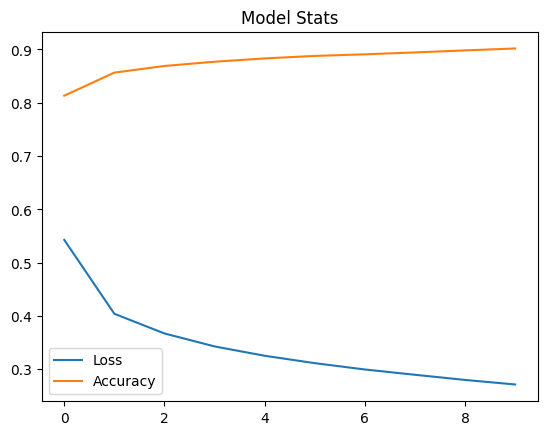

In [38]:
plt.plot(model_stats["epochs"], model_stats["loss"], label="Loss")
plt.plot(model_stats["epochs"], model_stats["accuracy"], label="Accuracy")
plt.title("Model Stats")
plt.legend()
plt.show()

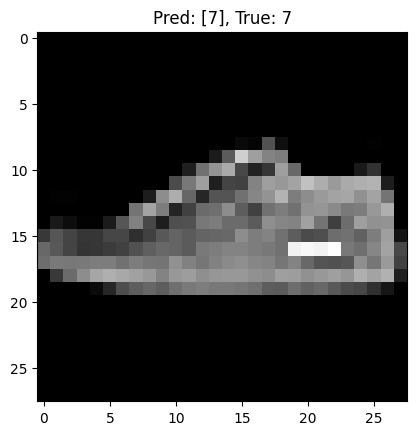

In [45]:
idx = np.random.randint(test_X.shape[1])   # random sample index

x = test_X[:, idx:idx+1]    # shape (784, 1)
y_true = test_y[idx]

y_pred = nn.predict(x)

plt.imshow(x.reshape(28,28), cmap="gray")
plt.title(f"Pred: {y_pred}, True: {y_true}")
plt.show()